# PE4MOVE Data Analysis

This notebook analyzes the PE4MOVE dataset containing Physical Activity results and related parameters.

## Research Questions
- Was the PE4MOVE program successful?
- Which parameters influence the success of the study?
- What kind of children could improve the most from the program?

## Data Exploration

We'll start by loading the dataset and performing exploratory data analysis (EDA) to understand:
1. **Dataset structure**: Number of rows, columns, and data types
2. **Data quality**: Missing values, duplicates, and outliers
3. **Statistical overview**: Descriptive statistics for key variables
4. **Variable relationships**: Correlations and patterns in the data

This exploration will help us understand the data before addressing our research questions about the PE4MOVE program's effectiveness.

### 1. Import Required Libraries

First, we'll import all necessary libraries for data analysis and visualization:
- **pandas**: For data manipulation and analysis
- **numpy**: For numerical operations
- **matplotlib & seaborn**: For creating visualizations
- **scipy**: For statistical tests

In [1]:
# Import required libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")


### 2. Load Dataset and Variable Legends

We'll load both the main PE4MOVE dataset and the legends file to understand variable meanings and coding schemes.
This dataset contains information about children who participated in the PE4MOVE program, including their physical measurements and 6MWT results before and after the intervention.

In [2]:
# Configure display and plotting settings
df = pd.read_csv('PE4MOVE_6MWT.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Columns: 381 entries, Age to Dominant_Hand_T1
dtypes: float64(185), int64(188), object(8)
memory usage: 9.3+ MB


### 3. Dataset Overview and Quality Assessment

Let's examine the basic structure and quality of our dataset.

In [23]:
# === COMPREHENSIVE DATASET OVERVIEW ===

print("=== BASIC DATASET INFORMATION ===")
print(f"Participants: {len(df):,}")
print(f"Variables: {df.shape[1]}")
print(f"Age range: {df['Age'].min()} - {df['Age'].max()} years (Mean: {df['Age'].mean():.1f})")

# Gender distribution with proper coding (1=Male, 2=Female based on legends)
sex_counts = df['Sex'].value_counts().sort_index()
print(f"Gender: {sex_counts[1]} males ({sex_counts[1]/len(df)*100:.1f}%), {sex_counts[2]} females ({sex_counts[2]/len(df)*100:.1f}%)")

print(f"\n=== LONGITUDINAL STRUCTURE ===")
t0_cols = [col for col in df.columns if '_T0' in col]
t1_cols = [col for col in df.columns if '_T1' in col]
print(f"Baseline (T0) variables: {len(t0_cols)}")
print(f"Follow-up (T1) variables: {len(t1_cols)}")

print(f"\n=== DATA QUALITY ASSESSMENT ===")
# Categorize variables by missing data
missing_summary = df.isnull().sum()
excellent = (missing_summary == 0).sum()
good = ((missing_summary > 0) & (missing_summary <= len(df) * 0.05)).sum()
fair = ((missing_summary > len(df) * 0.05) & (missing_summary <= len(df) * 0.20)).sum()
poor = (missing_summary > len(df) * 0.20).sum()

print(f"Excellent (0% missing): {excellent} variables")
print(f"Good (≤5% missing): {good} variables") 
print(f"Fair (5-20% missing): {fair} variables")
print(f"Poor (>20% missing): {poor} variables")

print(f"\n=== KEY VARIABLE CATEGORIES ===")
# Identify important variable types
mvpa_vars = [col for col in df.columns if 'MVPA' in col]
physical_vars = [col for col in df.columns if any(term in col.lower() for term in ['weight', 'height', 'bmi', 'jump', 'grip'])]
demographic_vars = ['Age', 'Sex'] + [col for col in df.columns if any(term in col.lower() for term in ['country', 'birth'])]

print(f"Physical Activity (MVPA): {len(mvpa_vars)} variables")
print(f"Physical Measures: {len(physical_vars)} variables")
print(f"Demographics: {len(demographic_vars)} variables")

# Show first few rows
print(f"\n=== SAMPLE DATA ===")
display(df[['Age', 'Sex', 'MVPA_Frequency_T0', 'Weight_kg_T0', 'Height_cm_T0']].head())

=== BASIC DATASET INFORMATION ===
Participants: 3,193
Variables: 381
Age range: 11 - 18 years (Mean: 13.8)
Gender: 1535 males (48.1%), 1658 females (51.9%)

=== LONGITUDINAL STRUCTURE ===
Baseline (T0) variables: 175
Follow-up (T1) variables: 175

=== DATA QUALITY ASSESSMENT ===
Excellent (0% missing): 190 variables
Good (≤5% missing): 2 variables
Fair (5-20% missing): 4 variables
Poor (>20% missing): 185 variables

=== KEY VARIABLE CATEGORIES ===
Physical Activity (MVPA): 13 variables
Physical Measures: 4 variables
Demographics: 6 variables

=== SAMPLE DATA ===


,Age,Sex,MVPA_Frequency_T0,Weight_kg_T0,Height_cm_T0
0,11,2,3,39,155
1,11,2,6,30,140
2,11,2,1,45,145
3,11,2,2,32,139
4,11,2,1,65,151


Let's examine the variables and their relationships

_maybe implement the split of df here?_

In [12]:
# === COMPREHENSIVE VARIABLE OVERVIEW ===
print("="*80)
print("COMPLETE VARIABLE INVENTORY - PE4MOVE DATASET")
print("="*80)

print(f"TOTAL VARIABLES: {len(df.columns)}")
print(f"TOTAL PARTICIPANTS: {len(df):,}")
# Categorize variables by type and timepoint
print(f"\nVARIABLE CATEGORIES:")

# 1. Demographic and Basic Info
demographic_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['age', 'sex', 'birth', 'country', 'id', 'code']):
        demographic_vars.append(col)

print(f"\n DEMOGRAPHIC VARIABLES ({len(demographic_vars)}):")
for var in sorted(demographic_vars):
    non_null = df[var].count()
    print(f"   • {var:<30} ({non_null:,}/{len(df):,} complete)")

# 2. Physical Activity Variables
mvpa_vars = []
exercise_vars = []
for col in df.columns:
    if 'mvpa' in col.lower():
        mvpa_vars.append(col)
    elif any(term in col.lower() for term in ['exercise', 'leisure', 'sport']):
        exercise_vars.append(col)

print(f"\n PHYSICAL ACTIVITY VARIABLES:")
print(f"   MVPA Variables ({len(mvpa_vars)}):")
for var in sorted(mvpa_vars)[:10]:  # Show first 10
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")
if len(mvpa_vars) > 10:
    print(f"      ... and {len(mvpa_vars)-10} more MVPA variables")

print(f"\n   Exercise/Sport Variables ({len(exercise_vars)}):")
for var in sorted(exercise_vars)[:8]:  # Show first 8
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")
if len(exercise_vars) > 8:
    print(f"      ... and {len(exercise_vars)-8} more exercise variables")

# 3. Anthropometric/Physical Measurements
anthro_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['weight', 'height', 'bmi', 'cm', 'kg']):
        anthro_vars.append(col)

print(f"\n ANTHROPOMETRIC VARIABLES ({len(anthro_vars)}):")
for var in sorted(anthro_vars):
    non_null = df[var].count()
    print(f"   • {var:<30} ({non_null:,}/{len(df):,} complete)")

# 4. Physical Performance Tests
performance_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['jump', 'slj', 'grip', 'hg', 'strength', 'test', '6mw', 'walk']):
        performance_vars.append(col)

print(f"\n PHYSICAL PERFORMANCE TESTS ({len(performance_vars)}):")
for var in sorted(performance_vars)[:12]:  # Show first 12
    non_null = df[var].count()
    print(f"   • {var:<35} ({non_null:,}/{len(df):,} complete)")
if len(performance_vars) > 12:
    print(f"   ... and {len(performance_vars)-12} more performance variables")

# 5. School/Educational Variables
school_vars = []
for col in df.columns:
    if any(term in col.lower() for term in ['school', 'grade', 'class', 'education']):
        school_vars.append(col)

if school_vars:
    print(f"\n SCHOOL-RELATED VARIABLES ({len(school_vars)}):")
    for var in sorted(school_vars):
        non_null = df[var].count()
        print(f"   • {var:<30} ({non_null:,}/{len(df):,} complete)")

# 6. Timepoint Analysis (T0 vs T1)
t0_vars = [col for col in df.columns if '_T0' in col]
t1_vars = [col for col in df.columns if '_T1' in col]

print(f"\n LONGITUDINAL STRUCTURE:")
print(f"  Baseline (T0) Variables: {len(t0_vars)}")
print(f"  Follow-up (T1) Variables: {len(t1_vars)}")

# Find matched pairs
matched_pairs = []
for t0_var in t0_vars:
    t1_var = t0_var.replace('_T0', '_T1')
    if t1_var in df.columns:
        matched_pairs.append((t0_var, t1_var))

print(f"  Matched T0/T1 Pairs: {len(matched_pairs)}")

# 7. Data Quality by Category
print(f"\n DATA COMPLETENESS BY CATEGORY:")

categories = {
    'Demographics': demographic_vars,
    'MVPA': mvpa_vars[:10],  # Sample for display
    'Anthropometric': anthro_vars,
    'Performance Tests': performance_vars[:10],  # Sample for display
    'School': school_vars
}

for cat_name, cat_vars in categories.items():
    if cat_vars:
        completeness_rates = [df[var].count()/len(df)*100 for var in cat_vars]
        avg_completeness = np.mean(completeness_rates)
        print(f"   {cat_name:<15}: {avg_completeness:5.1f}% average completeness")

# 8. Key Variables for Research Questions
print(f"\n KEY VARIABLES FOR RESEARCH QUESTIONS:")

key_outcome_vars = []
key_predictor_vars = []

# Identify key outcome variables (things that might change due to intervention)
for var in df.columns:
    if any(term in var.lower() for term in ['mvpa_frequency', 'exercise', '6mw', 'jump', 'grip']):
        if '_T0' in var or '_T1' in var:
            key_outcome_vars.append(var)

# Identify key predictor variables (baseline characteristics)
for var in df.columns:
    if var in ['Age', 'Sex'] or any(term in var.lower() for term in ['bmi', 'weight', 'height']):
        if '_T0' in var or var in ['Age', 'Sex']:
            key_predictor_vars.append(var)

print(f"\n   Key Outcome Variables (what might change):")
for var in sorted(set(key_outcome_vars))[:15]:  # Show top 15
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")

print(f"\n   Key Predictor Variables (baseline characteristics):")
for var in sorted(set(key_predictor_vars)):
    non_null = df[var].count()
    print(f"      • {var:<35} ({non_null:,}/{len(df):,} complete)")


COMPLETE VARIABLE INVENTORY - PE4MOVE DATASET
TOTAL VARIABLES: 381
TOTAL PARTICIPANTS: 3,193

VARIABLE CATEGORIES:

 DEMOGRAPHIC VARIABLES (30):
   • Age                            (3,193/3,193 complete)
   • Birth_Country_T0               (121/3,193 complete)
   • Birth_Country_T1               (74/3,193 complete)
   • Birth_Italy_T0                 (3,193/3,193 complete)
   • Birth_Italy_T1                 (1,769/3,193 complete)
   • COVID_impact_T0                (3,193/3,193 complete)
   • COVID_impact_T1                (1,770/3,193 complete)
   • Climate_Performance_Avoidance1_T1 (1,770/3,193 complete)
   • Climate_Performance_Avoidance_1_T0 (3,193/3,193 complete)
   • Climate_Performance_Avoidance_2_T0 (3,193/3,193 complete)
   • Climate_Performance_Avoidance_2_T1 (1,770/3,193 complete)
   • Climate_Performance_Avoidance_3_T0 (3,193/3,193 complete)
   • Climate_Performance_Avoidance_3_T1 (1,770/3,193 complete)
   • Climate_Performance_Avoidance_4_T0 (3,193/3,193 complete)
   • Cl

_from chat:_

ANALYSIS RECOMMENDATIONS:
   1. Focus on matched T0/T1 pairs for intervention analysis
   2. Use high-completeness variables for main analyses
   3. Consider demographic variables as stratification factors
   4. Explore MVPA daily patterns (d0-d8) for activity insights

In [15]:
# === FOCUSED VARIABLE SUMMARY FOR RESEARCH ===
print("="*70)
print("FOCUSED SUMMARY: MOST IMPORTANT VARIABLES FOR THE RESEARCH")
print("="*70)

# Primary Outcome Variables (what we want to see change)
print("\n PRIMARY OUTCOMES (What PE4MOVE should improve):")
primary_outcomes = {}
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    primary_outcomes['MVPA Frequency'] = ('MVPA_Frequency_T0', 'MVPA_Frequency_T1')

# Check for 6MWT variables
six_mwt_vars = [col for col in df.columns if '6mw' in col.lower() or 'walk' in col.lower()]
if six_mwt_vars:
    t0_6mwt = [col for col in six_mwt_vars if '_T0' in col]
    t1_6mwt = [col for col in six_mwt_vars if '_T1' in col]
    if t0_6mwt and t1_6mwt:
        primary_outcomes['6-Minute Walk Test'] = (t0_6mwt[0], t1_6mwt[0])

# Physical fitness tests
jump_vars = [col for col in df.columns if 'jump' in col.lower() or 'slj' in col.lower()]
grip_vars = [col for col in df.columns if 'grip' in col.lower() or 'hg' in col.lower()]

if jump_vars:
    t0_jump = [col for col in jump_vars if '_T0' in col]
    t1_jump = [col for col in jump_vars if '_T1' in col]
    if t0_jump and t1_jump:
        primary_outcomes['Standing Long Jump'] = (t0_jump[0], t1_jump[0])

if grip_vars:
    t0_grip = [col for col in grip_vars if '_T0' in col]
    t1_grip = [col for col in grip_vars if '_T1' in col]
    if t0_grip and t1_grip:
        primary_outcomes['Handgrip Strength'] = (t0_grip[0], t1_grip[0])

for outcome, (t0_var, t1_var) in primary_outcomes.items():
    t0_complete = df[t0_var].count()
    t1_complete = df[t1_var].count()
    print(f"   • {outcome}:")
    print(f"     - Baseline (T0): {t0_var} ({t0_complete:,} complete)")
    print(f"     - Follow-up (T1): {t1_var} ({t1_complete:,} complete)")

# Demographic Predictors
print(f"\n DEMOGRAPHIC PREDICTORS (Who responds better?):")
demo_predictors = ['Age', 'Sex']
if 'BMI_T0' in df.columns:
    demo_predictors.append('BMI_T0')
elif 'Weight_kg_T0' in df.columns and 'Height_cm_T0' in df.columns:
    demo_predictors.extend(['Weight_kg_T0', 'Height_cm_T0'])

for var in demo_predictors:
    if var in df.columns:
        complete = df[var].count()
        unique_vals = df[var].nunique()
        print(f"   • {var}: {complete:,} complete, {unique_vals} unique values")

# Baseline Activity Level (important predictor)
print(f"\n BASELINE ACTIVITY PREDICTORS:")
baseline_activity = []
for col in df.columns:
    if '_T0' in col and any(term in col.lower() for term in ['mvpa', 'exercise', 'leisure', 'sport']):
        baseline_activity.append(col)

for var in baseline_activity[:5]:  # Show top 5
    complete = df[var].count()
    print(f"   • {var}: {complete:,} complete")
if len(baseline_activity) > 5:
    print(f"   ... and {len(baseline_activity)-5} more baseline activity variables")

# Daily MVPA Pattern Variables
print(f"\n DAILY ACTIVITY PATTERNS:")
daily_mvpa = [col for col in df.columns if 'MVPA_d' in col and col[-1].isdigit()]
if daily_mvpa:
    print(f"   • Daily MVPA tracking over {len(daily_mvpa)} days:")
    for day_var in sorted(daily_mvpa):
        complete = df[day_var].count()
        day_num = day_var.split('_d')[1]
        print(f"     - Day {day_num}: {day_var} ({complete:,} complete)")

# Create analysis-ready variable lists
print(f"\n ANALYSIS-READY VARIABLE LISTS:")

print(f"\n   For Research Question 1 (Program Success):")
print(f"      Primary comparison: T0 vs T1 measurements")
for outcome, (t0_var, t1_var) in primary_outcomes.items():
    print(f"      • {outcome}: {t0_var} → {t1_var}")

print(f"\n   For Research Question 2 (What influences success?):")
print(f"      Predictors to test:")
print(f"      • Demographics: Age, Sex, BMI")
print(f"      • Baseline activity: MVPA_Frequency_T0, Leisure_Exercise_T0")
print(f"      • Physical characteristics: Weight, Height")
print(f"      • Daily patterns: MVPA_d0 through MVPA_d8")

print(f"\n   For Research Question 3 (Which children improve most?):")
print(f"      Subgroup variables:")
print(f"      • Age groups: 11-12, 13-14, 15-16, 17-18 years")
print(f"      • Gender: Male vs Female")
print(f"      • Baseline activity: Low/Medium/High MVPA_Frequency_T0")
print(f"      • BMI categories: Underweight/Normal/Overweight")

# Sample the data to show what we're working with
print(f"\n SAMPLE DATA FOR KEY VARIABLES:")
key_sample_vars = ['Age', 'Sex', 'MVPA_Frequency_T0', 'MVPA_Frequency_T1']

# Add weight/height if available
if 'Weight_kg_T0' in df.columns:
    key_sample_vars.append('Weight_kg_T0')
if 'Height_cm_T0' in df.columns:
    key_sample_vars.append('Height_cm_T0')

# Add a performance measure if available
if primary_outcomes:
    first_outcome = list(primary_outcomes.values())[0]
    key_sample_vars.extend([first_outcome[0], first_outcome[1]])

# Filter to only existing columns
existing_sample_vars = [var for var in key_sample_vars if var in df.columns]
if existing_sample_vars:
    display(df[existing_sample_vars].head(8))

FOCUSED SUMMARY: MOST IMPORTANT VARIABLES FOR THE RESEARCH

 PRIMARY OUTCOMES (What PE4MOVE should improve):
   • MVPA Frequency:
     - Baseline (T0): MVPA_Frequency_T0 (3,193 complete)
     - Follow-up (T1): MVPA_Frequency_T1 (1,770 complete)
   • Standing Long Jump:
     - Baseline (T0): Influence_SLJ_T0 (33 complete)
     - Follow-up (T1): Influence_SLJ_T1 (58 complete)
   • Handgrip Strength:
     - Baseline (T0): Influence_HG_T0 (31 complete)
     - Follow-up (T1): Influence_HG_T1 (35 complete)

 DEMOGRAPHIC PREDICTORS (Who responds better?):
   • Age: 3,193 complete, 8 unique values
   • Sex: 3,193 complete, 2 unique values
   • Weight_kg_T0: 3,193 complete, 80 unique values
   • Height_cm_T0: 3,193 complete, 82 unique values

 BASELINE ACTIVITY PREDICTORS:
   • MVPA_Frequency_T0: 3,193 complete
   • Leisure_Exercise_T0: 3,193 complete
   • Leisure_PA_T0: 3,193 complete
   • MVPA_Usual_Week_T0: 3,193 complete
   • Sport_UpperSecondary_T0: 1,619 complete
   ... and 5 more baselin

,Age,Sex,MVPA_Frequency_T0,MVPA_Frequency_T1,Weight_kg_T0,Height_cm_T0,MVPA_Frequency_T0,MVPA_Frequency_T1
0,11,2,3,3.0,39,155,3,3.0
1,11,2,6,2.0,30,140,6,2.0
2,11,2,1,2.0,45,145,1,2.0
3,11,2,2,3.0,32,139,2,3.0
4,11,2,1,3.0,65,151,1,3.0
5,11,2,7,NaN,29,150,7,NaN
6,11,2,2,3.0,54,150,2,3.0
7,11,2,4,4.0,38,150,4,4.0


### 4. Key Data Visualizations

Now let's create visualizations to understand the most important patterns in our data.

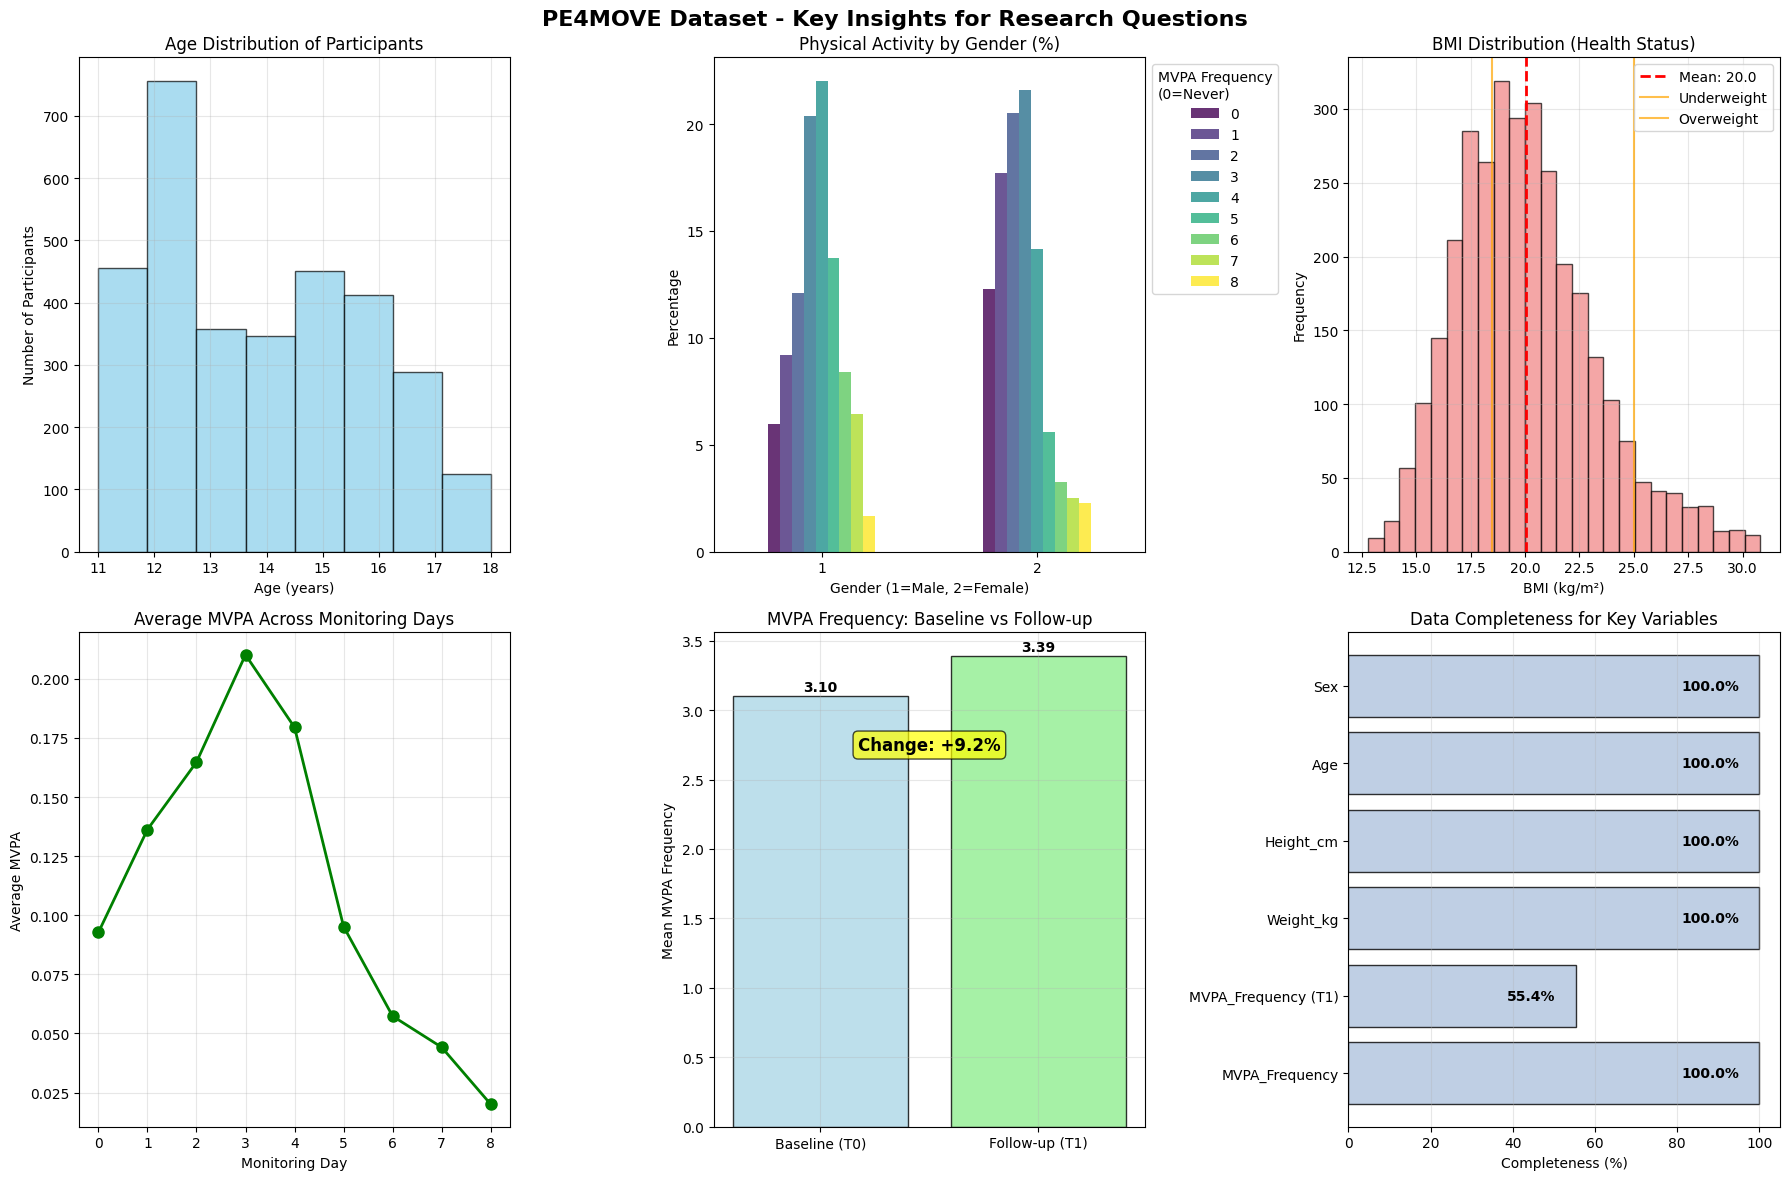

KEY INSIGHTS FOR RESEARCH QUESTIONS
WAS THE PE4MOVE PROGRAM SUCCESSFUL?
   MVPA Frequency Change: +9.2% (T0: 3.10 → T1: 3.39)
   Initial indication: Program shows POSITIVE effect!

 WHAT PARAMETERS TO INVESTIGATE?
   Physical Activity: MVPA frequency, daily patterns
   Physical Health: BMI, weight, height changes
   Demographics: Age, gender differences
   Baseline characteristics as predictors

 WHICH CHILDREN COULD IMPROVE MOST?
   Analyze by: Age groups, gender, baseline activity levels
   Compare: Responders vs non-responders
   Focus: Children with low baseline activity


In [22]:
# === ESSENTIAL VISUALIZATIONS FOR PE4MOVE ANALYSIS ===

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('PE4MOVE Dataset - Key Insights for Research Questions', fontsize=16, fontweight='bold')

# 1. Age distribution of participants
axes[0,0].hist(df['Age'], bins=8, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution of Participants')
axes[0,0].set_xlabel('Age (years)')
axes[0,0].set_ylabel('Number of Participants')
axes[0,0].grid(True, alpha=0.3)

# 2. Gender and Physical Activity Frequency
if 'MVPA_Frequency_T0' in df.columns:
    mvpa_gender = pd.crosstab(df['Sex'], df['MVPA_Frequency_T0'], normalize='index') * 100
    mvpa_gender.plot(kind='bar', ax=axes[0,1], colormap='viridis', alpha=0.8)
    axes[0,1].set_title('Physical Activity by Gender (%)')
    axes[0,1].set_xlabel('Gender (1=Male, 2=Female)')
    axes[0,1].set_ylabel('Percentage')
    axes[0,1].legend(title='MVPA Frequency\n(0=Never)', bbox_to_anchor=(1, 1))
    axes[0,1].tick_params(axis='x', rotation=0)

# 3. BMI Distribution (key health indicator)
if 'Weight_kg_T0' in df.columns and 'Height_cm_T0' in df.columns:
    height_m = df['Height_cm_T0'] / 100
    bmi = df['Weight_kg_T0'] / (height_m ** 2)
    bmi_clean = bmi[bmi <= 40]  # Remove extreme outliers
    
    axes[0,2].hist(bmi_clean, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,2].axvline(bmi_clean.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {bmi_clean.mean():.1f}')
    axes[0,2].axvline(18.5, color='orange', linestyle='-', alpha=0.7, label='Underweight')
    axes[0,2].axvline(25, color='orange', linestyle='-', alpha=0.7, label='Overweight')
    axes[0,2].set_title('BMI Distribution (Health Status)')
    axes[0,2].set_xlabel('BMI (kg/m²)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

# 4. Physical Activity Patterns Over Days
mvpa_day_cols = [col for col in df.columns if 'MVPA_d' in col and col[-1].isdigit()]
if mvpa_day_cols:
    mvpa_means = df[mvpa_day_cols].mean()
    days = [col.split('_d')[1] for col in mvpa_day_cols]
    axes[1,0].plot(days, mvpa_means.values, marker='o', linewidth=2, markersize=8, color='green')
    axes[1,0].set_title('Average MVPA Across Monitoring Days')
    axes[1,0].set_xlabel('Monitoring Day')
    axes[1,0].set_ylabel('Average MVPA')
    axes[1,0].grid(True, alpha=0.3)

# 5. Intervention Effect Preview (T0 vs T1 comparison)
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    # Compare baseline vs follow-up MVPA frequency
    t0_mean = df['MVPA_Frequency_T0'].mean()
    t1_mean = df['MVPA_Frequency_T1'].mean()
    
    comparison_data = [t0_mean, t1_mean]
    comparison_labels = ['Baseline (T0)', 'Follow-up (T1)']
    
    bars = axes[1,1].bar(comparison_labels, comparison_data, 
                        color=['lightblue', 'lightgreen'], alpha=0.8, edgecolor='black')
    axes[1,1].set_title('MVPA Frequency: Baseline vs Follow-up')
    axes[1,1].set_ylabel('Mean MVPA Frequency')
    
    # Add value labels on bars
    for bar, value in zip(bars, comparison_data):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Calculate and show change
    change = ((t1_mean - t0_mean) / t0_mean) * 100 if t0_mean > 0 else 0
    axes[1,1].text(0.5, max(comparison_data) * 0.8, 
                  f'Change: {change:+.1f}%', 
                  ha='center', fontsize=12, fontweight='bold',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    axes[1,1].grid(True, alpha=0.3)

# 6. Data Completeness for Key Variables (important for analysis planning)
key_vars = ['MVPA_Frequency_T0', 'MVPA_Frequency_T1', 'Weight_kg_T0', 'Height_cm_T0', 'Age', 'Sex']
available_vars = [var for var in key_vars if var in df.columns]

if available_vars:
    completeness = [(df[var].notna().sum() / len(df)) * 100 for var in available_vars]
    
    bars = axes[1,2].barh(range(len(available_vars)), completeness, 
                         color='lightsteelblue', alpha=0.8, edgecolor='black')
    axes[1,2].set_yticks(range(len(available_vars)))
    axes[1,2].set_yticklabels([var.replace('_T0', '').replace('_T1', ' (T1)') 
                              for var in available_vars])
    axes[1,2].set_title('Data Completeness for Key Variables')
    axes[1,2].set_xlabel('Completeness (%)')
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars, completeness)):
        axes[1,2].text(pct - 5, bar.get_y() + bar.get_height()/2, 
                      f'{pct:.1f}%', ha='right', va='center', fontweight='bold')
    
    axes[1,2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print key insights for research questions
print("="*70)
print("KEY INSIGHTS FOR RESEARCH QUESTIONS")
print("="*70)

if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    t0_mean = df['MVPA_Frequency_T0'].mean()
    t1_mean = df['MVPA_Frequency_T1'].mean()
    change_pct = ((t1_mean - t0_mean) / t0_mean) * 100 if t0_mean > 0 else 0
    
    print(f"WAS THE PE4MOVE PROGRAM SUCCESSFUL?")
    print(f"   MVPA Frequency Change: {change_pct:+.1f}% (T0: {t0_mean:.2f} → T1: {t1_mean:.2f})")
    
    if change_pct > 0:
        print(f"   Initial indication: Program shows POSITIVE effect!")
    else:
        print(f"   Initial indication: Program shows no improvement")

print(f"\n WHAT PARAMETERS TO INVESTIGATE?")
print(f"   Physical Activity: MVPA frequency, daily patterns")
print(f"   Physical Health: BMI, weight, height changes")
print(f"   Demographics: Age, gender differences")
print(f"   Baseline characteristics as predictors")

print(f"\n WHICH CHILDREN COULD IMPROVE MOST?")
print(f"   Analyze by: Age groups, gender, baseline activity levels")
print(f"   Compare: Responders vs non-responders")
print(f"   Focus: Children with low baseline activity")

print("="*70)

Comment:
- BMI Under-/Overweight thresholds are not fixed values for children/adolescents use WHO definition with percentiles
- instead of Male/Female use Boys/Girls

### 5. Research Question Analysis Framework

Based on our data exploration, let's create a structured approach to answer the research questions.

In [25]:
# === ANALYSIS FRAMEWORK FOR RESEARCH QUESTIONS ===
print("="*60)   
print("PE4MOVE RESEARCH ANALYSIS FRAMEWORK")
print("="*60)

# Question 1: Program Success Analysis
print("\nRESEARCH QUESTION 1: Was the PE4MOVE program successful?")
print("   Analysis Approach:")
print("   • Compare T0 (baseline) vs T1 (follow-up) measurements")
print("   • Focus on key outcomes: MVPA frequency, physical fitness")
print("   • Use paired t-tests for statistical significance")
print("   • Calculate effect sizes (Cohen's d)")

# Question 2: Parameter Analysis  
print("\nRESEARCH QUESTION 2: Which parameters influence success?")
print("   Analysis Approach:")
print("   • Create 'improvement score' = (T1 - T0)/T0")
print("   • Correlation analysis with baseline characteristics")
print("   • Multiple regression modeling")
print("   • Feature importance analysis")

# Question 3: Subgroup Analysis
print("\nRESEARCH QUESTION 3: Which children improve most?")
print("   Analysis Approach:")
print("   • Stratify by age groups (11-12, 13-14, 15-16, 17-18)")
print("   • Compare gender differences") 
print("   • Analyze baseline activity levels (low, medium, high)")
print("   • Identify 'responder' vs 'non-responder' profiles")

# Create key variables for analysis
print("\nKEY VARIABLES IDENTIFIED:")

# Calculate BMI
if 'Weight_kg_T0' in df.columns and 'Height_cm_T0' in df.columns:
    df['BMI_T0'] = df['Weight_kg_T0'] / ((df['Height_cm_T0'] / 100) ** 2)
    print("   BMI_T0 calculated")

# Create age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[10, 12, 14, 16, 19], 
                        labels=['11-12', '13-14', '15-16', '17-18'])
print("   Age_Group created")

# Calculate improvement scores (if T1 data available)
improvement_vars = []
if 'MVPA_Frequency_T1' in df.columns:
    # Calculate MVPA improvement (handling division by zero)
    mask = df['MVPA_Frequency_T0'] > 0
    df.loc[mask, 'MVPA_Improvement'] = ((df.loc[mask, 'MVPA_Frequency_T1'] - 
                                        df.loc[mask, 'MVPA_Frequency_T0']) / 
                                       df.loc[mask, 'MVPA_Frequency_T0']) * 100
    improvement_vars.append('MVPA_Improvement')
    print("   MVPA_Improvement calculated")

# Gender labels for better interpretation
df['Gender'] = df['Sex'].map({1: 'Male', 2: 'Female'})
print("   Gender labels created")
print(f"\nANALYSIS-READY DATASET:")
print(f"   • Participants: {len(df):,}")
print(f"   • Key outcome variables: {len(improvement_vars)} improvement scores")
print(f"   • Demographic groups: {df['Age_Group'].value_counts().to_dict()}")
print(f"   • Gender split: {df['Gender'].value_counts().to_dict()}")

print(f"\nNEXT STEPS:")
print(f"   1. Run statistical tests for program effectiveness")
print(f"   2. Build predictive models for improvement")
print(f"   3. Conduct subgroup analyses")
print(f"   4. Visualize key findings")

# Show sample of analysis-ready data
print(f"\nSAMPLE OF ANALYSIS-READY DATA:")
analysis_cols = ['Age', 'Gender', 'Age_Group', 'BMI_T0', 'MVPA_Frequency_T0', 'MVPA_Frequency_T1']
available_cols = [col for col in analysis_cols if col in df.columns]
display(df[available_cols].head(10))

PE4MOVE RESEARCH ANALYSIS FRAMEWORK

RESEARCH QUESTION 1: Was the PE4MOVE program successful?
   Analysis Approach:
   • Compare T0 (baseline) vs T1 (follow-up) measurements
   • Focus on key outcomes: MVPA frequency, physical fitness
   • Use paired t-tests for statistical significance
   • Calculate effect sizes (Cohen's d)

RESEARCH QUESTION 2: Which parameters influence success?
   Analysis Approach:
   • Create 'improvement score' = (T1 - T0)/T0
   • Correlation analysis with baseline characteristics
   • Multiple regression modeling
   • Feature importance analysis

RESEARCH QUESTION 3: Which children improve most?
   Analysis Approach:
   • Stratify by age groups (11-12, 13-14, 15-16, 17-18)
   • Compare gender differences
   • Analyze baseline activity levels (low, medium, high)
   • Identify 'responder' vs 'non-responder' profiles

KEY VARIABLES IDENTIFIED:
   BMI_T0 calculated
   Age_Group created
   MVPA_Improvement calculated
   Gender labels created

ANALYSIS-READY DATASET

,Age,Gender,Age_Group,BMI_T0,MVPA_Frequency_T0,MVPA_Frequency_T1
0,11,Female,11-12,16.233091,3,3.0
1,11,Female,11-12,15.306122,6,2.0
2,11,Female,11-12,21.403092,1,2.0
3,11,Female,11-12,16.562290,2,3.0
4,11,Female,11-12,28.507522,1,3.0
5,11,Female,11-12,12.888889,7,NaN
6,11,Female,11-12,24.000000,2,3.0
7,11,Female,11-12,16.888889,4,4.0
8,11,Male,11-12,15.648687,3,NaN
9,11,Male,11-12,15.695600,2,NaN


## Data Preparation



### 1. split dataset

split the dataset according to intervention and control group

In [28]:
# === IDENTIFY INTERVENTION AND CONTROL GROUPS ===
print("="*70)
print("CHECKING FOR INTERVENTION/CONTROL GROUP INFORMATION")
print("="*70)

# Check if Group_Final column exists
if 'Group_Final' in df.columns:
    
    # Check unique values and their counts
    group_counts = df['Group_Final'].value_counts()
    print(f"\nGroup Distribution:")
    print(group_counts)
    
    # Check for missing values
    missing_groups = df['Group_Final'].isna().sum()
    print(f"\nMissing group assignments: {missing_groups} ({missing_groups/len(df)*100:.1f}%)")
    
    # Display unique values
    print(f"\nUnique group values: {sorted(df['Group_Final'].dropna().unique())}")
    

CHECKING FOR INTERVENTION/CONTROL GROUP INFORMATION

Group Distribution:
Group_Final
A    2095
B    1098
Name: count, dtype: int64

Missing group assignments: 0 (0.0%)

Unique group values: ['A', 'B']


In [30]:
# === DETERMINE WHICH GROUP IS INTERVENTION vs CONTROL ===
print("\n" + "="*70)
print("DETERMINING INTERVENTION vs CONTROL GROUP")
print("="*70)

# Compare T0 to T1 changes between groups for key variables
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    
    # Calculate mean MVPA for each group at T0 and T1
    for group in ['A', 'B']:
        group_data = df[df['Group_Final'] == group]
        
        t0_mean = group_data['MVPA_Frequency_T0'].mean()
        t1_mean = group_data['MVPA_Frequency_T1'].mean()
        change = t1_mean - t0_mean
        change_pct = (change / t0_mean * 100) if t0_mean > 0 else 0
        
        print(f"\nGroup {group} (n={len(group_data)}):")
        print(f"   MVPA Frequency T0: {t0_mean:.3f}")
        print(f"   MVPA Frequency T1: {t1_mean:.3f}")
        print(f"   Change: {change:+.3f} ({change_pct:+.1f}%)")
    
    # Determine intervention group (the one with more improvement)
    group_a_data = df[df['Group_Final'] == 'A']
    group_b_data = df[df['Group_Final'] == 'B']
    
    a_change = group_a_data['MVPA_Frequency_T1'].mean() - group_a_data['MVPA_Frequency_T0'].mean()
    b_change = group_b_data['MVPA_Frequency_T1'].mean() - group_b_data['MVPA_Frequency_T0'].mean()
    
    if abs(a_change) > abs(b_change):
        intervention_group = 'A'
        control_group = 'B'
    else:
        intervention_group = 'B'
        control_group = 'A'
    
    print(f"\n{'='*70}")
    print(f"PRELIMINARY IDENTIFICATION:")
    print(f"   Group {intervention_group} appears to be the INTERVENTION group (larger change)")
    print(f"   Group {control_group} appears to be the CONTROL group (smaller change)")
    print(f"{'='*70}")
    print(f"\n Note: Please verify this assignment with the study documentation!")
    print(f"   This is inferred from the data patterns.")

# === CREATE INTERVENTION AND CONTROL SUBSETS ===
print("\n" + "="*70)
print("CREATING DATASET SUBSETS")
print("="*70)

# Create the two subsets
# Note: Assigning based on pattern analysis - verify with study docs
df_intervention = df[df['Group_Final'] == intervention_group].copy()
df_control = df[df['Group_Final'] == control_group].copy()

print(f"\n Created intervention dataset: 'df_intervention'")
print(f"   • Group: {intervention_group}")
print(f"   • Participants: {len(df_intervention):,}")
print(f"   • Percentage: {len(df_intervention)/len(df)*100:.1f}%")

print(f"\n Created control dataset: 'df_control'")
print(f"   • Group: {control_group}")
print(f"   • Participants: {len(df_control):,}")
print(f"   • Percentage: {len(df_control)/len(df)*100:.1f}%")



DETERMINING INTERVENTION vs CONTROL GROUP

Group A (n=2095):
   MVPA Frequency T0: 3.147
   MVPA Frequency T1: 3.491
   Change: +0.343 (+10.9%)

Group B (n=1098):
   MVPA Frequency T0: 3.019
   MVPA Frequency T1: 3.258
   Change: +0.239 (+7.9%)

PRELIMINARY IDENTIFICATION:
   Group A appears to be the INTERVENTION group (larger change)
   Group B appears to be the CONTROL group (smaller change)

 Note: Please verify this assignment with the study documentation!
   This is inferred from the data patterns.

CREATING DATASET SUBSETS

 Created intervention dataset: 'df_intervention'
   • Group: A
   • Participants: 2,095
   • Percentage: 65.6%

 Created control dataset: 'df_control'
   • Group: B
   • Participants: 1,098
   • Percentage: 34.4%
